## **Project details**

`The goal of this project is to conduct customer segmentation based on RFM analysis using kmeans clustering algorithm. `

`The data used is the Online Retail Data Set from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/online+retail), and it is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail`

### **RFM Analysis**

`RFM (Recency, Frequency, Monetary) analysis is a powerful customer segmentation technique used in marketing and customer relationship management. It helps businesses gain insights into customer behavior and identify valuable customer segments.`

`In RFM analysis, three key metrics are considered:`

`Recency: Measures how recent a customer made a purchase. It quantifies the time elapsed since the last transaction.`

`Frequency: Represents how often a customer makes purchases within a specific time period. It provides insights into customer loyalty and engagement.`

`Monetary: Reflects the monetary value of a customer's purchases. It indicates the amount of money a customer has spent.`

### **Dataset Description**

`The Online Retail Data Set contains a wealth of information about customer transactions. It includes details such as the invoice date and invoice no. of the transaction, the items purchased, the quantity, and the customer's ID. The dataset allows us to explore the purchasing patterns of customers and identify the relationships between different products.`

`All the necessary data cleaning have already been done in this notebook (https://github.com/vaadewoyin/Association-Rule-Mining-for-Retail-Analytics-Market-Basket-Analysis-/blob/main/Market_Basket_Analysis_of_the_Online_Retail_Dataset_.ipynb)`


 `However, any other transformation that needs to be done for clustering will be done.`

In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#get the stored cleaned version of the online retail dataset
data=pd.read_csv('/content/drive/MyDrive/Data science projects/uci_online_retail_data_cleaned.csv')
rfm_data=data.copy()
#convert invoice date column to datetime 
rfm_data['InvoiceDate']=pd.to_datetime(rfm_data['InvoiceDate'])
#extract date from invoice date
rfm_data['InvoiceDate']=rfm_data.InvoiceDate.dt.date

In [3]:
#confirm data timeline
print('Min:',rfm_data['InvoiceDate'].min(),';  ',
      'Max:',rfm_data['InvoiceDate'].max())

Min: 2010-12-01 ;   Max: 2011-12-09


`The data contains transactions bewteen 2010-12-01 and 2011-12-09. For our rfm analysis, we will use the next day of the last transaction day in the dataset as cutoff.so,we are working with 10th of December, 2011 for the analysis`

In [4]:
#create hypothetical snap_shot date (Assuming nextday of last transaction day)
snapshot_date=rfm_data['InvoiceDate'].max() + datetime.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

In [5]:
#Aggregate data on customerid level for rfm analysis
rfm_data=rfm_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()),
    'InvoiceNo': 'count',             
    'TotalSpending':'sum'})
#rename columns 
rfm_data.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency',
                         'TotalSpending':'MonetaryValue'},inplace=True)
#check first few rows
rfm_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326 days,1,77183.60
12347.0,3 days,175,4167.78
12348.0,76 days,25,1373.64
12349.0,19 days,63,1231.91
12350.0,311 days,16,294.40


`The dataframe above shows the RFM values for each customer`

In [6]:
#convert recency datatype from datetime to integer for analysis'sake
rfm_data['Recency']=(rfm_data['Recency'].apply(lambda x: str(x)).str.split(' ').str.get(0)).astype('int')

### KMeans clustering

`K-means clustering is a popular unsupervised machine learning algorithm used to partition data into distinct groups or clusters. It aims to minimize the within-cluster sum of squares by iteratively assigning data points to clusters based on their similarity to the cluster centroids`

In [7]:
#extract RFM from RFM_data for kmeans clustering
rfm_data2=rfm_data[['Recency','Frequency','MonetaryValue']]

In [8]:
rfm_data2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4321 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4321 non-null   int64  
 1   Frequency      4321 non-null   int64  
 2   MonetaryValue  4321 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.0 KB


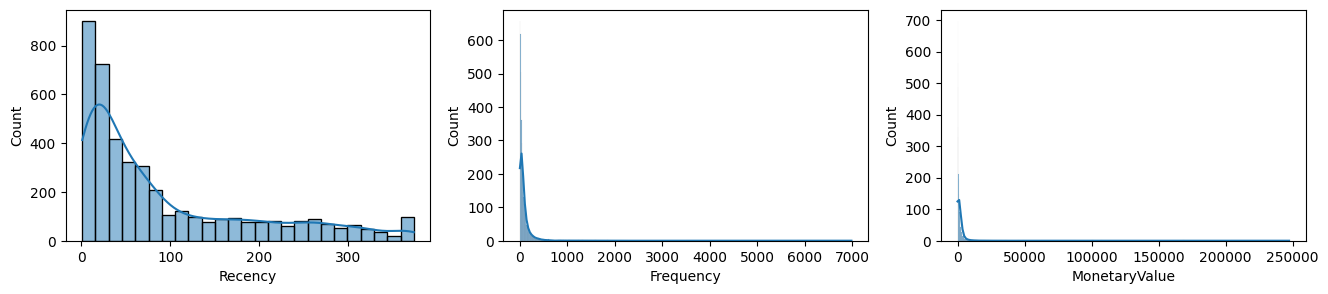

In [9]:
#check distribution of RFM features
fig,ax=plt.subplots(1,3,figsize=(16,3))
sns.histplot(data=rfm_data2,x='Recency',kde=True,ax=ax[0])
sns.histplot(data=rfm_data2,x='Frequency',kde=True,ax=ax[1])
sns.histplot(data=rfm_data2,x='MonetaryValue',kde=True,ax=ax[2])
plt.show()

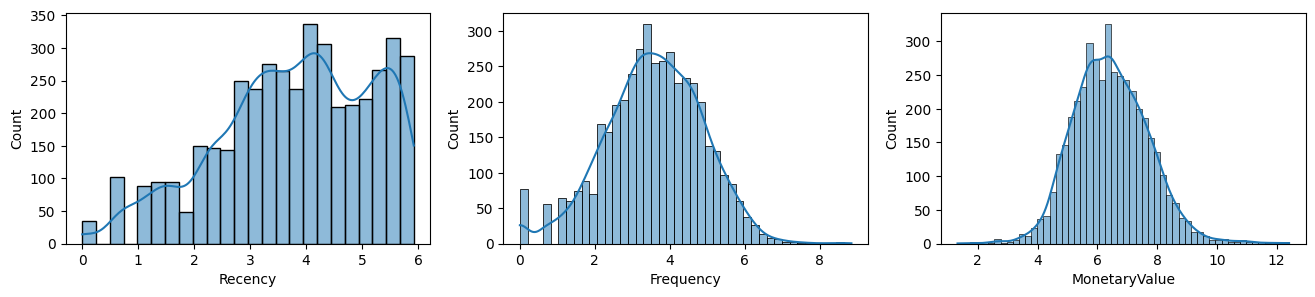

In [10]:
#Transform data to manage skewness
rfm_data2_log=np.log(rfm_data2)
#check distribution of log-transformed variables
fig,ax=plt.subplots(1,3,figsize=(16,3))
sns.histplot(data=rfm_data2_log,x='Recency',kde=True,ax=ax[0])
sns.histplot(data=rfm_data2_log,x='Frequency',kde=True,ax=ax[1])
sns.histplot(data=rfm_data2_log,x='MonetaryValue',kde=True,ax=ax[2])
plt.show()

In [11]:
#Standardized data
scaler=StandardScaler()
rfm_data2_log_scaled=scaler.fit_transform(rfm_data2_log)

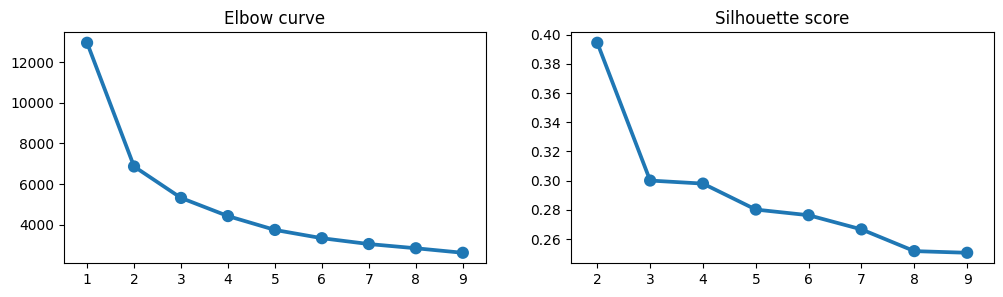

In [12]:
#finding the right K 
sse=[]
silhouette_avg_list=[]
k_values_for_silhouette_score=[]

for k in range(1,10):
  kmeans=KMeans(n_clusters=k,n_init='auto',random_state=12)
  kmeans.fit(rfm_data2_log_scaled)
  sse.append(kmeans.inertia_)
  cluster_labels = kmeans.labels_
  # Calculating the silhouette score
  try:
    silhouette_avg = silhouette_score(rfm_data2_log_scaled, cluster_labels)
    k_values_for_silhouette_score.append(k)
    silhouette_avg_list.append(silhouette_avg)
  except:
    continue

#plot 
fig,ax=plt.subplots(1,2,figsize=(12,3))
sns.pointplot(x=list(range(1,10)),y=sse,ax=ax[0])
sns.pointplot(x=k_values_for_silhouette_score,y=silhouette_avg_list,ax=ax[1])
ax[0].title.set_text('Elbow curve')
ax[1].title.set_text('Silhouette score')
plt.show()

`using the elbow method and the silhouette score, the best value of k is 2. however, it should be noted that the business requirement is also a key factor in deciding the value of k to use.`

In [13]:
#use k=2
kmeans=KMeans(n_clusters=2,n_init='auto',random_state=12)
kmeans.fit(rfm_data2_log_scaled)
#extract cluster label
cluster_label=kmeans.labels_
#add cluster columns to original dataframe
rfm_data_k2=rfm_data2.assign(Cluster=cluster_label)

In [14]:
#Calculate average RFM values and size for each cluster
k2=rfm_data_k2.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean',
                                     'MonetaryValue':['mean','count']}).round(0)
k2

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         141.0      23.0         426.0  2425
1          31.0     157.0        3524.0  1896

`Assuming our business need requires us to identify 3 clusters:`

In [15]:
#use k=3
kmeans=KMeans(n_clusters=3,n_init='auto',random_state=12)
kmeans.fit(rfm_data2_log_scaled)
#extract cluster label
cluster_label=kmeans.labels_
#add cluster columns to original dataframe
rfm_data_k3=rfm_data2.assign(Cluster=cluster_label)

#Calculate average RFM values and size for each cluster
k3=rfm_data_k3.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean',
                                     'MonetaryValue':['mean','count']}).round(0)
k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          70.0      58.0         994.0  1834
1          14.0     231.0        5640.0   974
2         172.0      14.0         262.0  1513

`From the segmentation shown above:`

`Cluster 0: These customers have a relatively recent purchase history but lower frequency and monetary value, They are responsible for nearly 24% of total revenue. To increase their engagement and loyalty, consider implementing targeted promotions, personalized offers, or loyalty programs to encourage more frequent and higher-value purchases.`

`Cluster 1: These customers are the most valuable, since they have a high frequency of purchases and significant monetary value. They are active and valuable customers. Focus on providing personalized recommendations, exclusive deals, and premium services to enhance their experience and maintain their loyalty.`

`Cluster 2: These customers have a longer recency period(mean recency is more than 5 months), lower frequency, and lower monetary value, and are most likely on the verge of churning.They account for about 5% of total revenue. It is important to adopt special strategies to prevent losing them. They may require additional incentives or reminders to make purchases. Consider implementing win-back campaigns, re-engagement strategies, or special discounts to reactivate their interest and encourage more frequent purchases.`















### Snake Plot



`In marketing analytics, a snake plot is a visual tool used to analyze and compare the performance of different products, brands, or marketing strategies across various attributes or metrics. A snake plot based on customer segments is a visual representation that allows for the comparison of different variables across different segments or groups of customers. It helps analyze how various factors or attributes vary across customer segments and identify patterns or differences between them.`

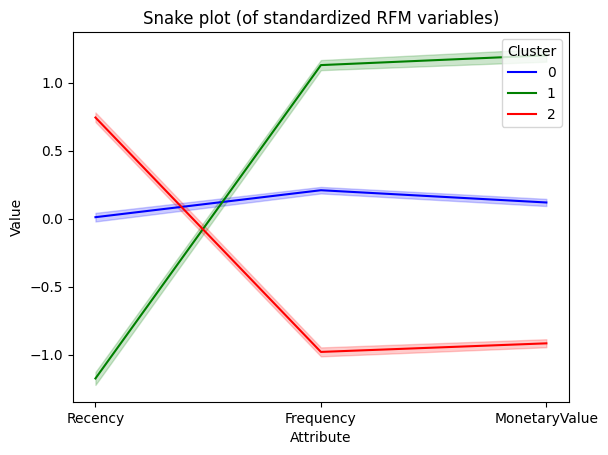

In [16]:
#create dataframe using scaled data
rfm_data2_norm=pd.DataFrame(rfm_data2_log_scaled,columns=scaler.feature_names_in_,
                            index=rfm_data2_log.index)
#add cluster column
rfm_data2_norm['Cluster']=rfm_data_k3.Cluster

#melt data into long format
rfm_data_melt=pd.melt(rfm_data2_norm.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',value_name='Value')

#snake plot
plt.title('Snake plot (of standardized RFM variables)')
sns.lineplot(data=rfm_data_melt, x='Attribute', y='Value', hue='Cluster',
             palette=['b','g','r'])
plt.show()

`The snake plot shows that cluster 1 has lowest recency ,while cluster 2 has the highest recency, with cluster 0 being in between. with respect to frequency and monetary values, cluster 1 has significantly high values compared to cluster 0 and cluster 2, with cluster 2 having the lowest values among the clusters.`